In [1]:
import librosa
import librosa.display
import soundfile
import numpy as np
import matplotlib.pyplot as plt
import glob
import stumpy
from tqdm.notebook import tqdm

# Parameters and preliminaries

In [2]:
n_fft = 2048
win_length = n_fft
hop_length = win_length // 32

In [3]:
mpw = librosa.time_to_frames(1, n_fft=n_fft, hop_length=hop_length, sr=10000)

In [4]:
def iter_all(pat):
    files = sorted(glob.glob(pat))
    for f in tqdm(files):
        yield soundfile.read(f)

In [5]:
def compute_amplitude(data_rate_pair, n_fft, win_length, hop_length):
    sr = data_rate_pair[1]
    return librosa.stft(data_rate_pair[0], n_fft=n_fft, win_length=win_length, hop_length=hop_length)

In [6]:
snippet, sr = soundfile.read('data/Cross_A_02_060203_071428.d20.x.flac')

In [7]:
amplitude = compute_amplitude((snippet, sr), n_fft, win_length, hop_length)
power = librosa.amplitude_to_db(np.abs(amplitude), ref=np.max)

In [8]:
freqs = librosa.fft_frequencies(n_fft=n_fft, sr=10000)
freqs_focus = np.where((freqs >= 360) & (freqs <= 370))
freqs_focus, freqs[freqs_focus]

((array([74, 75]),), array([361.328125 , 366.2109375]))

In [9]:
powerts = np.abs(amplitude[freqs_focus]).sum(axis=0)
powerts = librosa.power_to_db(powerts)
# sw = 20
# powerts = np.convolve(powerts, np.ones(sw), 'valid') / sw


In [10]:
mp = stumpy.stump(powerts, mpw)[:,0].astype(np.float64)

In [11]:
motifs = stumpy.motifs(powerts, mp, max_distance=2*np.min(mp))
motifs

(array([[8.08928582e-06, 1.40842001e+00, 1.54899714e+00, 2.16311409e+00,
         2.39946179e+00, 2.48322120e+00, 2.69354780e+00, 2.77839769e+00]]),
 array([[120981, 129438,  75484,  32452, 128016, 333335,  87311,  68023]]))

Herebelow we have a taste of what it means to focus on a particular frequency, looking at how the energy on that frequency changes through time. We have, from top top bottom, the spectrogram of a whale vocalizing, the amplitude of the frequencies around 362 Hz, and the corresponding matrix profile for a window of length 20 frames.

The yellow lines mark the minima of the matrix profile, i.e. the top motif, which correspond to a pair of similar vocalizations of the whale

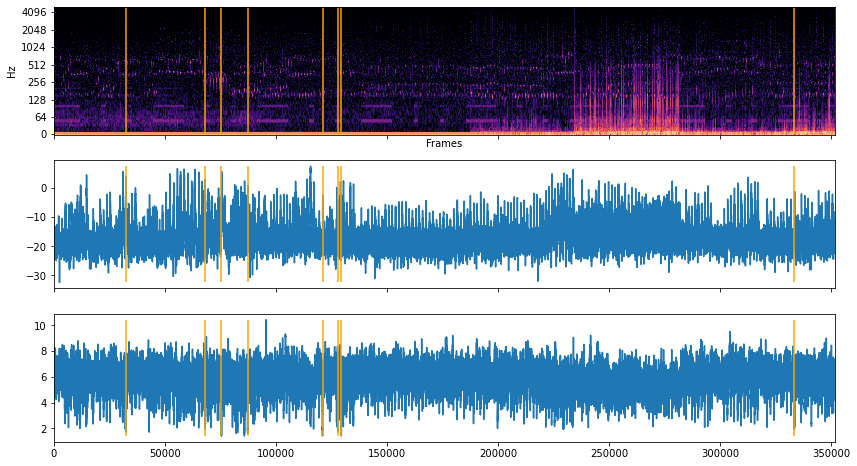

In [12]:
fig, axs = plt.subplots(3, figsize=(14, 8), sharex=True)
librosa.display.specshow(power, sr=10000, ax=axs[0], n_fft=n_fft, win_length=win_length, hop_length=hop_length, x_axis='frames', y_axis='log')
#axs[0].hlines(freqs[freqs_focus], color='white', xmin=0, xmax=500)
axs[1].plot(powerts)
axs[2].plot(mp)
axs[0].vlines(motifs[1][0], ymin=0, ymax=np.max(freqs), color='orange')
axs[1].vlines(motifs[1][0], ymin=np.min(powerts), ymax=np.max(powerts), color='orange')
axs[2].vlines(motifs[1][0], ymin=np.min(mp), ymax=np.max(mp), color='orange')

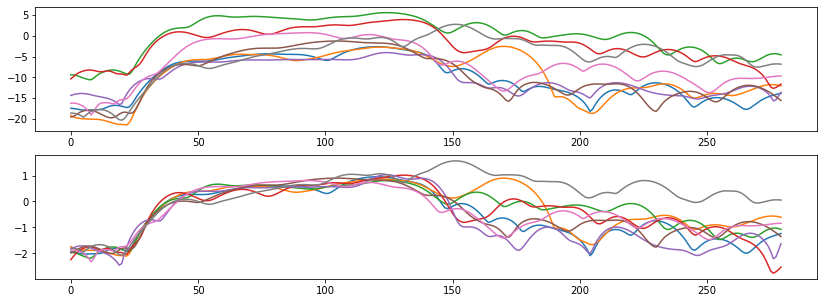

In [13]:
fig, axs = plt.subplots(2, figsize=(14,5))
for m in motifs[1][0]:
    subseq = powerts[m:m+2*mpw]
    znorm = (subseq - np.mean(subseq[:mpw])) / np.std(subseq[:mpw])
    axs[0].plot(subseq)
    axs[1].plot(znorm)

The motifs are shown here below: some of themare instances of a fundamental note, others are harmonics of a lower note.

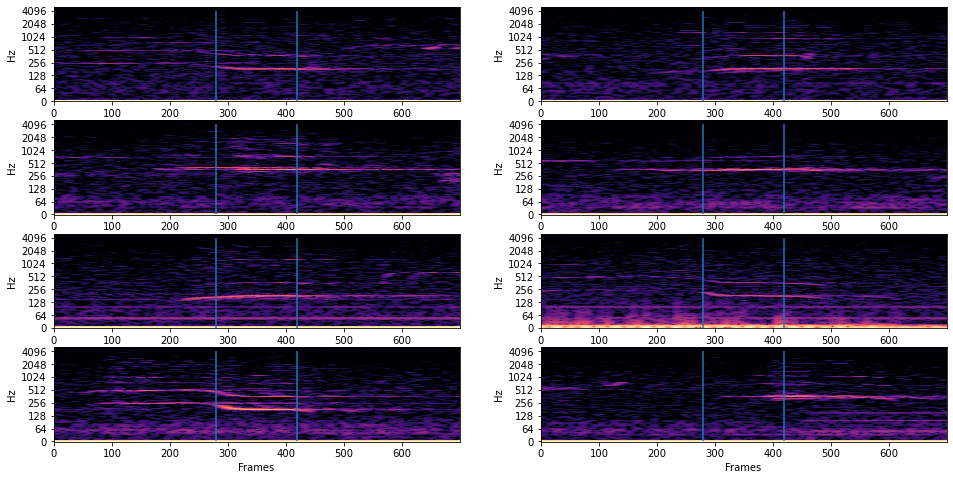

In [14]:
fig, axs = plt.subplots(ncols=2, nrows=len(motifs[1][0]) // 2, figsize=(16,8))
for ax, motif_idx in zip(axs.flatten(), motifs[1][0]):
    librosa.display.specshow(power[:,motif_idx-2*mpw:motif_idx+3*mpw], ax=ax, sr=10000, n_fft=n_fft, win_length=win_length, hop_length=hop_length, x_axis='frames', y_axis='log')
    ax.vlines([2*mpw, 3*mpw], ymin=0, ymax=4096)

# Building a univariate time series

In [15]:
#full = np.concatenate([p[0] for p in iter_all('data/Cross_A_02_06*.flac')])

In [16]:
# amplitudes = np.concatenate(list(map(
#     lambda p: np.abs(compute_amplitude(p, n_fft, win_length, hop_length)[freqs_focus].sum(axis=0)),
#     # lambda p: librosa.amplitude_to_db(np.abs(compute_amplitude(p, n_fft, win_length, hop_length))),
#     iter_all('data/Cross_A_02_06*.flac')
# )), axis=0)